In [1]:
from torchvision import models
models.resnet50 # 원본 코드 확인용

<function torchvision.models.resnet.resnet50(*, weights: Optional[torchvision.models.resnet.ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet>

In [2]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append('C:/Github/Deep-Learning-Study')

import torch
from model import Model
from TrainnTest import train, test
from torchvision import transforms, datasets
import torch.nn as nn

from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.1+cu118  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 3

train_dataset = datasets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

print(train_loader.dataset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


image indices: [ 8068 35810 16423 22890]


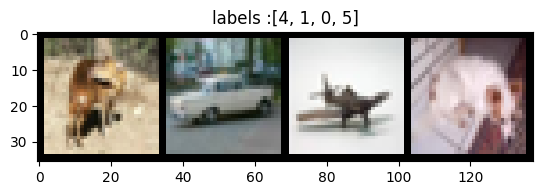

In [5]:
# 이미지 확인용
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

grid_size = 4
rnd_inds = np.random.randint(0, len(train_dataset), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_dataset[i][0] for i in rnd_inds]
y_grid = [train_dataset[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [6]:
model = Model().resnet18().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [7]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200, device=DEVICE, criterion=criterion, epoch=epoch)
    test_loss, test_accuracy = test(model, test_loader, device=DEVICE, criterion=criterion, batch_size=BATCH_SIZE, scheduler=scheduler)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.343215
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.303167
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.315320
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.326882
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.303316
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.289845
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.346936
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.350137

[EPOCH: 1], 	Test Loss: 2.5056, 	Test Accuracy: 9.81 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.292826
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.275597
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.325691
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.289397
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.303111
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 2.316318
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.331447
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.324342

[EPOCH: 2], 	Test Loss: 2.4317, 	Test Accuracy: 9.86 % 

